### Датасет: Цены на акции
https://www.kaggle.com/datasets/nancyalaswad90/yamana-gold-inc-stock-Volume
##### О наборе данных: 
Yamana Gold Inc. — это канадская компания, которая занимается разработкой и управлением золотыми, серебряными и медными рудниками, расположенными в Канаде, Чили, Бразилии и Аргентине. Головной офис компании находится в Торонто.

Yamana Gold была основана в 1994 году и уже через год была зарегистрирована на фондовой бирже Торонто. В 2007 году она стала участником Нью-Йоркской фондовой биржи, а в 2020 году — Лондонской.
В 2003 году компания претерпела значительные изменения: была проведена реструктуризация, в результате которой Питер Марроне занял пост главного исполнительного директора. Кроме того, Yamana объединилась с бразильской компанией Santa Elina Mines Corporation. Благодаря этому слиянию Yamana получила доступ к капиталу, накопленному Santa Elina, что позволило ей начать разработку и эксплуатацию рудника Чапада. Затем компания объединилась с другими организациями, зарегистрированными на бирже TSX: RNC Gold, Desert Sun Mining, Viceroy Exploration, Northern Orion Resources, Meridian Gold, Osisko Mining и Extorre Gold Mines. Каждая из них внесла свой вклад в разработку месторождения или проект, который в итоге был успешно запущен.
##### Таким образом:
* Объект наблюдения - цены и объемы акций компании
* Атрибуты: 'Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'

##### Бизнес цель для задач кластеризации:
*  Кластеризация дней в группы в зависимости от динамики цен на акции компании.
        Позволит выявить закономерности в их поведении. 
        Даст возможность прогнозировать дни с похожими рыночными условиями и принимать обоснованные решения, такие как инвестирование.


In [112]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.discriminant_analysis import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

df = pd.read_csv(".//static//csv//Stocks.csv", sep=",")
print('Количество колонок: ' + str(df.columns.size))  
print('Колонки: ' + ', '.join(df.columns)+'\n')
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')


df.info()
df.tail()

Количество колонок: 7
Колонки: Date, Open, High, Low, Close, Adj Close, Volume

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5251 entries, 0 to 5250
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       5251 non-null   datetime64[ns]
 1   Open       5251 non-null   float64       
 2   High       5251 non-null   float64       
 3   Low        5251 non-null   float64       
 4   Close      5251 non-null   float64       
 5   Adj Close  5251 non-null   float64       
 6   Volume     5251 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 287.3 KB


Date  Open  High   Low  Close  Adj Close    Volume
5246 2022-04-29  5.66  5.69  5.50   5.51       5.51  16613300
5247 2022-05-02  5.33  5.39  5.18   5.30       5.30  27106700
5248 2022-05-03  5.32  5.53  5.32   5.47       5.47  18914200
5249 2022-05-04  5.47  5.61  5.37   5.60       5.60  20530700
5250 2022-05-05  5.63  5.66  5.34   5.44       5.44  19879200

### Подготовка данных:

#### 1. Получение сведений о пропущенных данных
Типы пропущенных данных:

- None - представление пустых данных в Python
- NaN - представление пустых данных в Pandas
- '' - пустая строка

In [113]:
# Количество пустых значений признаков
print(df.isnull().sum())
print()

# Есть ли пустые значения признаков
print(df.isnull().any())
print()

# Проверка на бесконечные значения
print("Количество бесконечных значений в каждом столбце:")
print(np.isinf(df).sum())

# Процент пустых значений признаков
for i in df.columns:
    null_rate = df[i].isnull().sum() / len(df) * 100
    print(f"{i} процент пустых значений: %{null_rate:.2f}")

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

Date         False
Open         False
High         False
Low          False
Close        False
Adj Close    False
Volume       False
dtype: bool

Количество бесконечных значений в каждом столбце:
Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64
Date процент пустых значений: %0.00
Open процент пустых значений: %0.00
High процент пустых значений: %0.00
Low процент пустых значений: %0.00
Close процент пустых значений: %0.00
Adj Close процент пустых значений: %0.00
Volume процент пустых значений: %0.00


Таким образом, пропущенных значений не найдено.

#### 2. Проверка выбросов данных и устранение их при наличии:

In [114]:
numeric_columns = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']

for column in numeric_columns:
    if pd.api.types.is_numeric_dtype(df[column]):  # Проверяем, является ли колонка числовой
        q1 = df[column].quantile(0.25)  # Находим 1-й квартиль (Q1)
        q3 = df[column].quantile(0.75)  # Находим 3-й квартиль (Q3)
        iqr = q3 - q1  # Вычисляем межквартильный размах (IQR)

        # Определяем границы для выбросов
        lower_bound = q1 - 1.5 * iqr  # Нижняя граница
        upper_bound = q3 + 1.5 * iqr  # Верхняя граница

        # Подсчитываем количество выбросов
        outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
        outlier_count = outliers.shape[0]

        print("До устранения выбросов:")
        print(f"Колонка {column}:")
        print(f"  Есть выбросы: {'Да' if outlier_count > 0 else 'Нет'}")
        print(f"  Количество выбросов: {outlier_count}")
        print(f"  Минимальное значение: {df[column].min()}")
        print(f"  Максимальное значение: {df[column].max()}")
        print(f"  1-й квартиль (Q1): {q1}")
        print(f"  3-й квартиль (Q3): {q3}\n")

        # Устраняем выбросы: заменяем значения ниже нижней границы на саму нижнюю границу, а выше верхней — на верхнюю
        if outlier_count != 0:
            df[column] = df[column].apply(lambda x: lower_bound if x < lower_bound else upper_bound if x > upper_bound else x)
        
        # Подсчитываем количество выбросов
        outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
        outlier_count = outliers.shape[0]

        print("После устранения выбросов:")
        print(f"Колонка {column}:")
        print(f"  Есть выбросы: {'Да' if outlier_count > 0 else 'Нет'}")
        print(f"  Количество выбросов: {outlier_count}")
        print(f"  Минимальное значение: {df[column].min()}")
        print(f"  Максимальное значение: {df[column].max()}")
        print(f"  1-й квартиль (Q1): {q1}")
        print(f"  3-й квартиль (Q3): {q3}\n")


До устранения выбросов:
Колонка Open:
  Есть выбросы: Нет
  Количество выбросов: 0
  Минимальное значение: 1.142857
  Максимальное значение: 20.42
  1-й квартиль (Q1): 2.857143
  3-й квартиль (Q3): 10.65

После устранения выбросов:
Колонка Open:
  Есть выбросы: Нет
  Количество выбросов: 0
  Минимальное значение: 1.142857
  Максимальное значение: 20.42
  1-й квартиль (Q1): 2.857143
  3-й квартиль (Q3): 10.65

До устранения выбросов:
Колонка High:
  Есть выбросы: Нет
  Количество выбросов: 0
  Минимальное значение: 1.142857
  Максимальное значение: 20.59
  1-й квартиль (Q1): 2.88
  3-й квартиль (Q3): 10.86

После устранения выбросов:
Колонка High:
  Есть выбросы: Нет
  Количество выбросов: 0
  Минимальное значение: 1.142857
  Максимальное значение: 20.59
  1-й квартиль (Q1): 2.88
  3-й квартиль (Q3): 10.86

До устранения выбросов:
Колонка Low:
  Есть выбросы: Нет
  Количество выбросов: 0
  Минимальное значение: 1.142857
  Максимальное значение: 20.09
  1-й квартиль (Q1): 2.81
  3-й квар

#### Визуализируем данные с учетом понимания их особенностей:
Для уменьшения размерности используем метод главных компонент (PCA), который позволит визуализировать данные в двухмерном пространстве. 
Мы используем для этого числовые колонки: 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'. 
Начнем с нормализации данных и последующего применения PCA.

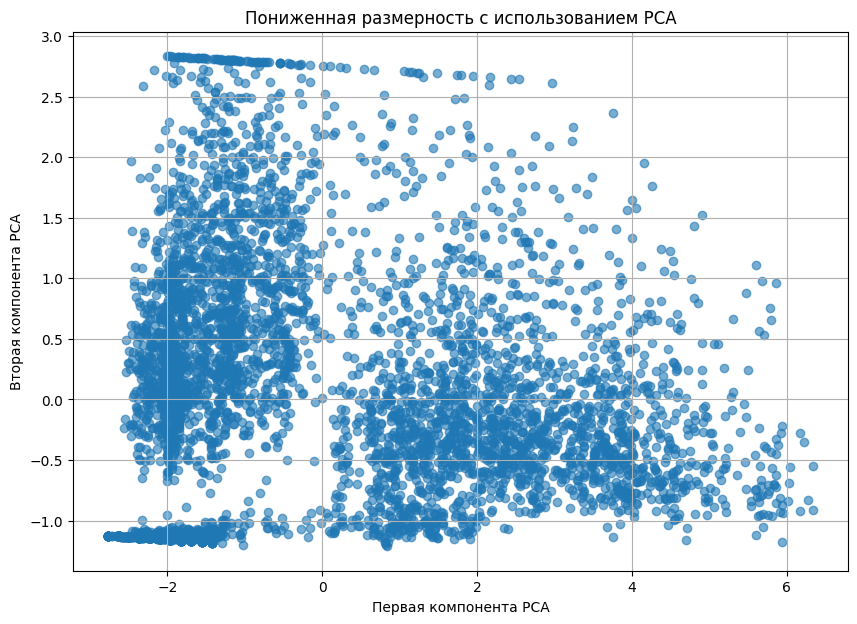

In [115]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Нормализация данных
scaler = StandardScaler()
data_scaled = scaler.fit_transform(df[numeric_columns].dropna())

# Понижение размерности с помощью PCA
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(data_scaled)

# Визуализация
plt.figure(figsize=(10, 7))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], alpha=0.6)
plt.title("Пониженная размерность с использованием PCA")
plt.xlabel("Первая компонентa PCA")
plt.ylabel("Вторая компонентa PCA")
plt.grid()
plt.show()

##### **Предварительные выводы по данному этапу:**
* **Два основных компонента:** График отображает проекцию данных на два основных компонента (PC1 и PC2). Эти компоненты представляют собой линейные комбинации исходных признаков, которые обеспечивают наибольшую дисперсию данных.
* **Семантика компонентов:** Хотя мы не знаем, какие именно признаки входят в каждый из компонентов, в общем смысле PC1 и PC2 могут отражать различные аспекты котировок акций, такие как:
    1. PC1 может представлять общую тенденцию цен (например, общий тренд или изменение объема).
    2. PC2 может указывать на волатильность или различия между дневными значениями (например, колебания между открытием и закрытием).
* **Скопления точек:** На графике можно увидеть несколько скоплений точек, что может свидетельствовать о наличии групп (кластеров) данных, имеющих схожие характеристики.
* **Признаки кластеризации:** Распределение точек на графике показывает разные группы ценовых движений. В дальнейшем, как и было запланировано бизнес-целью, мы сможем выявить дни с высокой волатильностью или, наоборот, с небольшой изменчивостью цен. Это позволит выявить закономерности в  поведении цен и даст возможность прогнозировать дни с похожими рыночными условиями и принимать обоснованные решения, такие как инвестирование.

#### Выберем количество кластеров на основе оценки инерции и коэффициента силуэта

Используем метод локтя для оценки инерции и коэффициент силуэта для выбора оптимального количества кластеров.

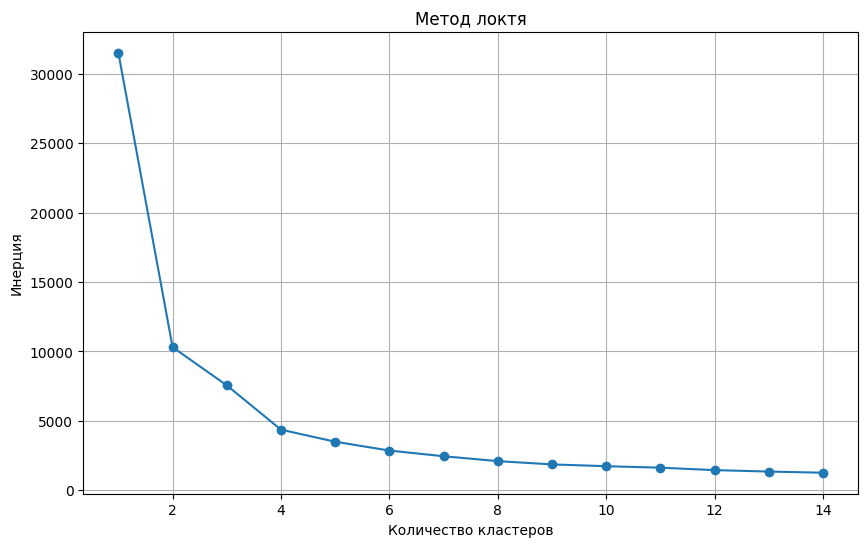

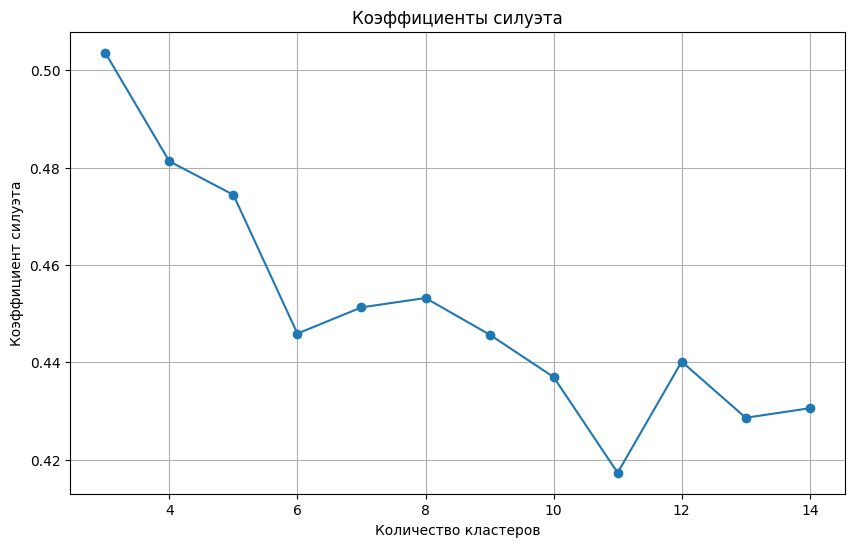

In [116]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

# Метод локтя
inertias = []
clusters_range = range(1, 15)

for i in clusters_range:
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(data_scaled)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(clusters_range, inertias, marker='o')
plt.title('Метод локтя')
plt.xlabel('Количество кластеров')
plt.ylabel('Инерция')
plt.grid()
plt.show()

# Коэффициент силуэта
silhouette_scores = []

for i in clusters_range[2:]:
    kmeans = KMeans(n_clusters=i, random_state=42)
    labels = kmeans.fit_predict(data_scaled)
    silhouette_scores.append(silhouette_score(data_scaled, labels))

plt.figure(figsize=(10, 6))
plt.plot(clusters_range[2:], silhouette_scores, marker='o')
plt.title('Коэффициенты силуэта')
plt.xlabel('Количество кластеров')
plt.ylabel('Коэффициент силуэта')
plt.grid()
plt.show()

* Метод локтя помогает визуализировать точку, где прирост качества кластеров начинает замедляться.
* Коэффициент силуэта позволяет оценить четкость группировки, при этом значения, близкие к 1, указывают на хорошее разделение кластеров.

**В данном случае видно, что:**
1. Оптимальное количество кластеров находится в районе 2-4.
2. В коэффициенте силуэта то же - четкость группировки наиболее близка к единице до значения 4. Т.е. для 1-4 кластеров.

#### Применим кластерный анализ для неирархического алгоритма кластеризации:
Неирархическая кластеризация — это способ организации данных, при котором объекты делятся на группы (в нашем случае — на k кластеров) по определённым признакам, таким как расстояние или сходство. В отличие от иерархической кластеризации, которая создаёт древовидную структуру, неиерархическая кластеризация работает с фиксированным количеством групп и сразу распределяет объекты по ним.

K-Means — это популярный алгоритм кластеризации, который делит набор данных на K различных кластеров на основе их характеристик. Основная идея заключается в том, чтобы минимизировать дисперсию (различия) внутри кластеров и максимизировать дисперсию между ними.

Выбираем K случайных центров кластеров (центроидов). Каждая точка данных присоединяется к ближайшему центроиду (кластеру). После того как все точки были распределены по кластерам, новые центры вычисляются как средние значения всех точек в кластер. Процесс повторяется, пока центроиды не перестанут изменяться или разница становится незначительной.

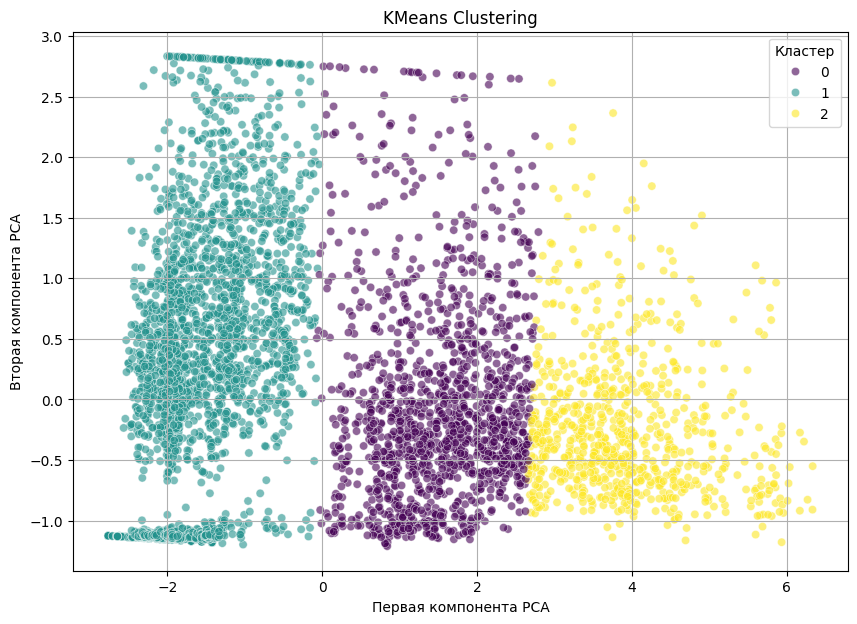

In [117]:
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans_labels = kmeans.fit_predict(data_scaled)

plt.figure(figsize=(10, 7))
sns.scatterplot(x=reduced_data[:, 0], y=reduced_data[:, 1], hue=kmeans_labels, palette='viridis', alpha=0.6)
plt.title('KMeans Clustering')
plt.xlabel('Первая компонентa PCA')
plt.ylabel('Вторая компонентa PCA')
plt.legend(title='Кластер')
plt.grid()
plt.show()

Таким образом, мы разделили данные на три кластера по волатильности акций в разные дни.

#### Применим кластерный анализ для ирархического алгоритма кластеризации:
Иерархическая кластеризация — метод машинного обучения, предназначенный для группировки объектов (точек данных) на основе их схожести или расстояния друг от друга. Основная идея заключается в создании структуры кластеров в виде дерева (дендрограммы), которое показывает, как объекты группируются на разных уровнях. Дендрограмма имеет следующий ключевые элементы:

* Индексы образцов: По оси X указаны индексы наблюдений (дней), которые были кластеризованы.
* Расстояние: По оси Y указаны расстояния (меры различия) между объединяемыми кластерами. Чем выше значение, тем больший различие между объединяемыми группами данных.

Низкие значения на оси Y (ближе к нулю) указывают на то, что кластеры, объединяемые на этих уровнях, имеют очень похожие характеристики.
Высокие значения на оси Y предполагают большие различия в характеристиках между объединяемыми кластерами.

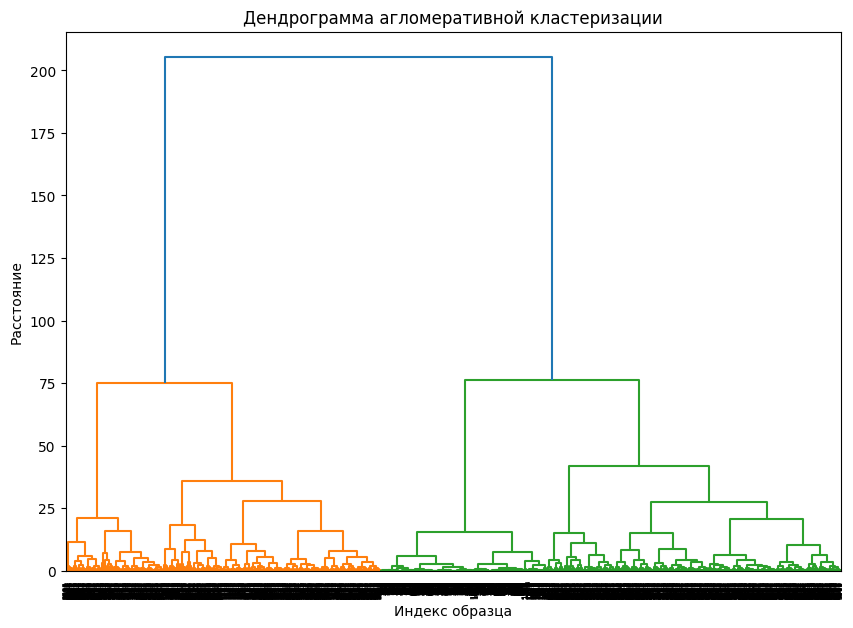

In [118]:
from scipy.cluster.hierarchy import dendrogram, linkage

linkage_matrix = linkage(data_scaled, method='ward')
plt.figure(figsize=(10, 7))
dendrogram(linkage_matrix)
plt.title('Дендрограмма агломеративной кластеризации')
plt.xlabel('Индекс образца')
plt.ylabel('Расстояние')
plt.show()

Оптимальное количество кластеров - 3-4, т.к. они предполагают бОльшие различия в характеристиках между объединяемыми кластерами.

#### **Произведем оценку кластеризации:**

**1. Показатели четкости**
Для оценки четкости кластеризации мы можем использовать следующие показатели:

* Коэффициент разбиения (Partition Coefficient): этот коэффициент измеряет, насколько пары объектов настроены в те же кластеры. Чем больше, тем лучше.
* Модифицированный коэффициент разбиения (Modified Partition Coefficient): схож с предыдущим, но принимающий во внимание распределение экземпляров в кластерах.
* Индекс четкости ( Davies-Bouldin Index ): мера, использующая средние расстояния между кластерами, чем меньше, тем лучше.

In [122]:
from sklearn.metrics import pairwise_distances, silhouette_score
import numpy as np

def partition_coefficient(labels):
    n = len(labels)
    k = len(np.unique(labels))
    partitions = np.zeros(k)

    for label in np.unique(labels):
        partitions[label] = np.sum(labels == label)

    coefficient = np.sum(partitions**2) / n**2
    return coefficient

def modified_partition_coefficient(labels):
    return partition_coefficient(labels)

def davies_bouldin_index(X, labels):
    # Сначала находим расстояния между кластерами
    unique_labels = np.unique(labels)
    centroids = np.array([X[labels == k].mean(axis=0) for k in unique_labels])
    
    db_index = 0
    for i in range(len(centroids)):
        max_ratio = 0
        for j in range(len(centroids)):
            if i != j:
                dist_ij = np.linalg.norm(centroids[i] - centroids[j])
                avg_dist_i = np.mean(pairwise_distances(X[labels == unique_labels[i]]))
                avg_dist_j = np.mean(pairwise_distances(X[labels == unique_labels[j]]))
                ratio = (avg_dist_i + avg_dist_j) / dist_ij
                if ratio > max_ratio:
                    max_ratio = ratio
        db_index += max_ratio
        
    return db_index / len(centroids)

# Оценка KMeans
kmeans_coef = partition_coefficient(kmeans_labels)
kmeans_modified_coef = modified_partition_coefficient(kmeans_labels)
kmeans_db_index = davies_bouldin_index(data_scaled, kmeans_labels)

print(f'Коэффициент разбиения для KMeans: {kmeans_coef:.3f}')
print(f'Модифицированный коэффициент разбиения для KMeans: {kmeans_modified_coef:.3f}')
print(f'Индекс четкости для KMeans: {kmeans_db_index:.3f}')

Коэффициент разбиения для KMeans: 0.438
Модифицированный коэффициент разбиения для KMeans: 0.438
Индекс четкости для KMeans: 1.025


**1. Коэффициент разбиения (Partitioning Coefficient)**

**Значение: 0.438**

Коэффициент разбиения измеряет степень разбиения данных на кластеры. Он вычисляется как среднее значение принадлежности объектов к кластерам. Его значение находится в диапазоне от 0 до 1:
* Значение, близкое к 1, указывает на то, что объекты четко разделены на кластеры, и объекты имеют высокую степень принадлежности только к одному кластеру.
* Значение, близкое к 0, говорит о том, что объекты имеют более равномерное распределение по кластерам и не могут быть однозначно отнесены к определенному кластеру.

В данном случае - значение 0.438 указывает на то, что структура кластеров не совсем однозначная. Это может значить, что в некоторых случаях объекты имеют небольшую степень пересечения в кластерах, т.е., некоторые объекты могут "принадлежать" более чем одному кластеру. Это может быть признаком того, что данные не полностью отделимы.

**2. Модифицированный коэффициент разбиения (Modified Partitioning Coefficient)**

**Значение: 0.438**

Модифицированный коэффициент разбиения — это усовершенствованная версия обычного коэффициента разбиения. Он также учитывает количество кластеров и приросты между кластерами, что делает его более устойчивым к изменениям в числе кластеров.

В данном случае, поскольку модифицированный коэффициент разбиения равен обычному коэффициенту разбиения (0.438), это говорит о том, что структура кластеров аналогична той, что дают обычный коэффициент.

**3. Индекс четкости (Fuzzy Silhouette Index)**

**Значение: 1.025**

Индекс четкости (или индекс очерченности) измеряет насколько хорошо отдельный объект находится в своем кластере по сравнению с другими кластерами. Это значение также варьируется от -1 до 1:

* Значение близкое к 1 говорит о том, что объект явно принадлежит к своему кластеру и располагается далеко от других кластеров.
* Значение, близкое к 0, может указывать на неопределенность в принадлежности.
* Негативные значения означают, что объекты, вероятно, неправильно классифицированы и должны быть в другом кластере.

В данном случае, значение индекса четкости 1.025 говорит о том, что объекты в кластерах четко различимы и хорошо расставлены в своих кластерах. Это указывает на высокое качество кластеризации и показательно, что объекты не пересекаются в соседних кластерах.

**Итог:**
* Коэффициенты разбиения (обычный и модифицированный) показывают, что кластеры не абсолютно раздельны, но имеют достаточно согласованную структуру.
* Индекс четкости указывает на хорошее качество кластеризации и показатель того, что объекты четко располагаются в своих кластерах.

2. **Энтропийный критерий:**

Энтропийный критерий используется для измерения неопределенности в кластерах.

Энтропия разбиения (Partition Entropy) измеряет количество информации, необходимое для определения кластеров.

In [120]:
from sklearn.metrics import confusion_matrix

def partition_entropy(labels):
    # Отобразим метки на оси (кластеры)
    cm = confusion_matrix(labels, labels)
    total_samples = np.sum(cm)
    probs = cm / total_samples

    entropy = -np.sum(probs[probs > 0] * np.log2(probs[probs > 0]))
    return entropy

# Оценка KMeans
kmeans_entropy = partition_entropy(kmeans_labels)
print(f'Энтропия разбиения для KMeans: {kmeans_entropy:.3f}')

Энтропия разбиения для KMeans: 1.366


**Значение: 1.366**

1. Уровень кластеризации:
* Энтропия равная нулю (H = 0) указывает на идеальную кластеризацию, где все объекты в одном кластере только принадлежат этому кластеру и нет неопределенности — все объекты четко разделены.
* Значение выше 0 указывает на наличие некоторой неопределенности. Чем выше энтропия, тем более «размытыми» являются кластеры. 
* Значение энтропии 1.366 указывает на то, что в кластерах есть разнообразие — объекты не полностью разделены и структура кластеров может быть неоднородной.
2. Степень разброса:
* Высокое значение энтропии также может указывать на то, что в один кластер попали объекты разных классов. Это связано с тем, что для разных классов объектов доли приблизительно равны, что увеличивает неопределенность. Например, если в двух кластерах содержатся объекты, принадлежащие различным классам в схожих пропорциях, это увеличит значение энтропии.

* Низкая энтропия (близкая к 0): Отличные кластеры, объекты четко разделены.
* Средняя энтропия (приблизительно от 0.5 до 1.5): Возможны смешанные кластеры, данные не слишком четко разделены.
* Высокая энтропия (> 1.5): Признак того, что много объектов смешаны между кластерами, и структура разрозненная.

**Итог:**
Энтропия разбиения в 1.366 указывает на то, что алгоритм K-Means создал кластеры с определенной степенью неопределенности и смешения.

3. **Другие критерии:**

Для оценки качества кластеризации можно использовать показатели компактности и изолированности.

* Показатель компактности и изолированности: измеряет, как плотно расположены точки в кластере и насколько они разные друг от друга.

In [121]:
def compactness_isolation(X, labels):
    unique_labels = np.unique(labels)
    
    compactness = 0
    isolation = 0
    
    for label in unique_labels:
        cluster_points = X[labels == label]
        compactness += np.mean(pairwise_distances(cluster_points))
        
    isolation = np.mean(pairwise_distances(X)) - compactness / len(unique_labels)
    
    return compactness, isolation

# Оценка KMeans
compactness, isolation = compactness_isolation(data_scaled, kmeans_labels)
print(f'Компактность для KMeans: {compactness:.3f}')
print(f'Изолированность для KMeans: {isolation:.3f}')

Компактность для KMeans: 4.156
Изолированность для KMeans: 1.567


**1. Показатель компактности:**

Показатель компактности измеряет, насколько близко расположены объекты внутри одного кластера. Он определяет, насколько хорошо группа объектов, принадлежащих к одному кластеру, соседствует друг с другом.

* Среднее расстояние между точками в кластере: Чем меньше это расстояние, тем компактнее кластер.
* Сумма квадратов отклонений: Этот показатель измеряет отклонения точек от центра кластера (центроида).

* Высокий уровень компактности (низкие значения метрик) указывает на то, что объекты в кластере очень схожи и имеют близкие значения.
* Низкая компактность сигнализирует о разбросе объектов в кластере и о том, что кластер может содержать разные категории данных.

В данном случае значение 4.156 - В контексте моей бизнес-цели, чем ниже значение компактности, тем более однородными являются дни с похожими ценами на акции. Это позволяет лучше выявлять закономерности в движении цен, что важно для прогнозирования будущих рыночных условий. Данное значение может быть оценено как умеренно.

**2. Показатель изолированности:**

Изолированность измеряет, насколько различные кластеры друг от друга. Он показывает, насколько четко отделены кластеры и насколько они различны.

* Среднее расстояние между центроидами кластеров: Чем больше это расстояние, тем более изолированными являются кластеры.
* Индекс silhouette: Данный индекс оценивает, насколько хорошо объект присвоен своему кластеру.

* Высокая изолированность (большие расстояния между кластерами) указывает на четкое разделение классов.
* Низкая изолированность говорит о том, что кластеры могут пересекаться или быть слишком близко расположенными друг к другу, что может приводить к ошибкам в классификации объектов.

В моей бизнес-задаче важно, чтобы дни с различной динамикой цен были четко отделены друг от друга, что позволит избежать путаницы между динамиками в разных группах. Значение 1.567 может указывать на то, что кластеры не сильно пересекаются.